In [2]:
# Import necessary libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from timm import create_model

print("Libraries imported successfully!")

Libraries imported successfully!


In [3]:
## Step 2: Define Custom Dataset
##We create a `PlantDataset` class to load images, labels, and (simulated) bounding boxes. The dataset supports both classification and detection.

In [4]:
# Custom Dataset Class
class PlantDataset(Dataset):
    def __init__(self, image_paths, labels, bboxes=None, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.bboxes = bboxes  # Bounding boxes (optional for detection)
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        if image is None:
            print(f"Failed to load image: {self.image_paths[idx]}")
            return None
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        bbox = self.bboxes[idx] if self.bboxes is not None else torch.zeros(4)  # [x_center, y_center, width, height]
        return image, label, bbox

print("PlantDataset class defined!")

PlantDataset class defined!


In [5]:
## Step 3: Load and Prepare Data
## **Path**: `/kaggle/input/plantvillage-dataset/color/`.
## **Classes**: 38 disease categories.
## **Split**: 80% train, 20% validation.
## **Bounding Boxes**: Simulated as centered boxes (replace with real annotations for actual detection).

In [6]:
# Data Loading
base_path = '/kaggle/input/plantvillage-dataset/color/'
classes = sorted(os.listdir(base_path))
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
image_paths, labels = [], []

# Load image paths and labels
for cls in classes:
    cls_path = os.path.join(base_path, cls)
    for img in os.listdir(cls_path):
        image_paths.append(os.path.join(cls_path, img))
        labels.append(class_to_idx[cls])

# Simulate bounding boxes (replace with real annotations if available)
bboxes = [np.array([0.5, 0.5, 0.4, 0.4]) for _ in range(len(image_paths))]  # Center of image, 40% width/height

# Split into train and validation
train_paths, val_paths, train_labels, val_labels, train_bboxes, val_bboxes = train_test_split(
    image_paths, labels, bboxes, test_size=0.2, stratify=labels, random_state=42
)

# Transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

# Datasets and DataLoaders
train_dataset = PlantDataset(train_paths, train_labels, train_bboxes, transform)
val_dataset = PlantDataset(val_paths, val_labels, val_bboxes, transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"Loaded {len(train_dataset)} training and {len(val_dataset)} validation samples across {len(classes)} classes.")

Loaded 43444 training and 10861 validation samples across 38 classes.


In [7]:
## Step 4: Define VMamba Block
## The VMamba block processes features from EfficientNet, enhancing spatial dependencies.

In [8]:
# VMamba Block
class MambaBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.ssm = nn.Conv1d(dim, dim, kernel_size=3, padding=1, groups=dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Linear(dim * 4, dim)
        )

    def forward(self, x):
        x = self.norm(x)
        x = x.permute(0, 2, 1)
        x = self.ssm(x)
        x = x.permute(0, 2, 1)
        return x + self.mlp(x)

print("MambaBlock defined!")

MambaBlock defined!


In [9]:
## Step 5: Define Model
##The model combines:
## **EfficientNet-B0**: Pre-trained backbone.
## **VMamba Blocks**: Feature processing.
## **YOLO-style Head**: Class probabilities + bounding box coordinates.

In [10]:
# EfficientNet + VMamba + YOLO-style Head
class EfficientNetVMambaYOLO(nn.Module):
    def __init__(self, num_classes=38, embed_dim=96, depth=4):
        super().__init__()
        self.backbone = create_model('efficientnet_b0', pretrained=True, features_only=True)
        self.feature_channels = self.backbone.feature_info[-1]['num_chs']
        self.channel_adjust = nn.Conv2d(self.feature_channels, embed_dim, kernel_size=1)
        self.vmamba_blocks = nn.Sequential(*[MambaBlock(embed_dim) for _ in range(depth)])
        self.grid_size = 7
        self.pred_head = nn.Linear(embed_dim, num_classes + 4)  # Class probs + bbox (x, y, w, h)

    def forward(self, x):
        x = self.backbone(x)[-1]  # (B, C, 7, 7)
        x = self.channel_adjust(x)
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)  # (B, H*W, C)
        x = self.vmamba_blocks(x)
        x = x.view(B, self.grid_size, self.grid_size, -1)
        x = self.pred_head(x)  # (B, 7, 7, num_classes + 4)
        return x

print("Model defined!")

Model defined!


In [11]:
## Step 6: Define Loss Function
## **Classification Loss**: CrossEntropyLoss.
## **Detection Loss**: MSELoss for bounding boxes.
## **Total Loss**: Weighted combination (bbox loss scaled by 0.1).

In [12]:
# Loss Function
def compute_loss(outputs, labels, bboxes, num_classes=38):
    criterion_cls = nn.CrossEntropyLoss()
    criterion_bbox = nn.MSELoss()
    
    # Extract center cell for classification
    center_cell = outputs[:, 3, 3, :]  # (B, num_classes + 4)
    cls_output = center_cell[:, :num_classes]  # (B, num_classes)
    bbox_output = center_cell[:, num_classes:]  # (B, 4)
    
    # Classification loss
    cls_loss = criterion_cls(cls_output, labels)
    
    # Bounding box loss
    bbox_loss = criterion_bbox(bbox_output, bboxes)
    
    # Total loss
    total_loss = cls_loss + 0.1 * bbox_loss
    return total_loss, cls_loss, bbox_loss

print("Loss function defined!")

Loss function defined!


In [13]:
## Step 7: Train the Model
## **Epochs**: 5.
## **Optimizer**: Adam (lr=0.001).
## **Device**: GPU (CUDA).

In [14]:
# Train & Evaluate
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EfficientNetVMambaYOLO(num_classes=len(classes)).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(80):
    model.train()
    total_loss, total_cls_loss, total_bbox_loss = 0, 0, 0
    for images, labels, bboxes in train_loader:
        images = images.to(device).float()
        labels = labels.to(device)
        bboxes = bboxes.to(device).float()

        outputs = model(images)  # (B, 7, 7, num_classes + 4)
        loss, cls_loss, bbox_loss = compute_loss(outputs, labels, bboxes, len(classes))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_cls_loss += cls_loss.item()
        total_bbox_loss += bbox_loss.item()

    print(f"Epoch {epoch+1}, Total Loss: {total_loss:.4f}, Class Loss: {total_cls_loss:.4f}, BBox Loss: {total_bbox_loss:.4f}")


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Epoch 1, Total Loss: 395.6335, Class Loss: 394.0477, BBox Loss: 15.8586
Epoch 2, Total Loss: 139.4514, Class Loss: 139.2551, BBox Loss: 1.9635
Epoch 3, Total Loss: 110.6385, Class Loss: 110.5454, BBox Loss: 0.9308
Epoch 4, Total Loss: 89.9451, Class Loss: 89.8935, BBox Loss: 0.5164
Epoch 5, Total Loss: 82.0027, Class Loss: 81.9697, BBox Loss: 0.3302
Epoch 6, Total Loss: 68.9185, Class Loss: 68.8963, BBox Loss: 0.2221
Epoch 7, Total Loss: 55.2789, Class Loss: 55.2615, BBox Loss: 0.1743
Epoch 8, Total Loss: 49.5783, Class Loss: 49.5690, BBox Loss: 0.0931
Epoch 9, Total Loss: 46.8262, Class Loss: 46.8195, BBox Loss: 0.0670
Epoch 10, Total Loss: 41.7587, Class Loss: 41.7485, BBox Loss: 0.1022
Epoch 11, Total Loss: 38.1635, Class Loss: 38.1592, BBox Loss: 0.0434
Epoch 12, Total Loss: 38.2369, Class Loss: 38.2251, BBox Loss: 0.1175
Epoch 13, Total Loss: 29.4504, Class Loss: 29.4403, BBox Loss: 0.1009
Epoch 14, Total Loss: 30.9734, Class Loss: 30.9695, BBox Loss: 0.0392
Epoch 15, Total Loss: 

In [15]:
## Step 8: Evaluate the Model
## **Metrics**: Accuracy, precision, recall, F1-score for classification; MSE for bounding boxes.
## **Validation**: Use the validation split.

In [16]:
# Evaluation
model.eval()
preds, trues, pred_bboxes, true_bboxes = [], [], [], []
with torch.no_grad():
    for images, labels, bboxes in val_loader:
        images, labels, bboxes = images.to(device), labels.to(device), bboxes.to(device)
        outputs = model(images)
        
        center_cell = outputs[:, 3, 3, :]
        cls_outputs = center_cell[:, :len(classes)]
        bbox_outputs = center_cell[:, len(classes):]
        
        _, predicted = torch.max(cls_outputs, 1)
        preds.extend(predicted.cpu().numpy())
        trues.extend(labels.cpu().numpy())
        pred_bboxes.extend(bbox_outputs.cpu().numpy())
        true_bboxes.extend(bboxes.cpu().numpy())

# Metrics
acc = np.mean(np.array(preds) == np.array(trues)) * 100
precision = precision_score(trues, preds, average='weighted')
recall = recall_score(trues, preds, average='weighted')
f1 = f1_score(trues, preds, average='weighted')
bbox_mse = np.mean((np.array(pred_bboxes) - np.array(true_bboxes)) ** 2)

print(f"\n--- Evaluation Results ---")
print(f"Validation Accuracy: {acc:.2f}%")
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1-score: {f1:.2f}")
print(f"Bounding Box MSE: {bbox_mse:.4f}")


--- Evaluation Results ---
Validation Accuracy: 99.56%
Precision: 1.00, Recall: 1.00, F1-score: 1.00
Bounding Box MSE: 0.0000


In [17]:
## Step 9: Save the Model
##Save the trained model weights.

In [18]:
# Save Model
torch.save(model.state_dict(), "/kaggle/working/efficient_vmamba_yolo.pth")
print("Model saved as efficient_vmamba_yolo.pth")

Model saved as efficient_vmamba_yolo.pth


In [19]:
## Step 10: Visualize Dataset
##Display one sample image per class.

The Number of Images in Apple___Apple_scab: 630
The Number of Images in Apple___Black_rot: 621
The Number of Images in Apple___Cedar_apple_rust: 275
The Number of Images in Apple___healthy: 1645
The Number of Images in Blueberry___healthy: 1502
The Number of Images in Cherry_(including_sour)___Powdery_mildew: 1052
The Number of Images in Cherry_(including_sour)___healthy: 854
The Number of Images in Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 513
The Number of Images in Corn_(maize)___Common_rust_: 1192
The Number of Images in Corn_(maize)___Northern_Leaf_Blight: 985
The Number of Images in Corn_(maize)___healthy: 1162
The Number of Images in Grape___Black_rot: 1180
The Number of Images in Grape___Esca_(Black_Measles): 1383
The Number of Images in Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 1076
The Number of Images in Grape___healthy: 423
The Number of Images in Orange___Haunglongbing_(Citrus_greening): 5507
The Number of Images in Peach___Bacterial_spot: 2297
The Number of Im

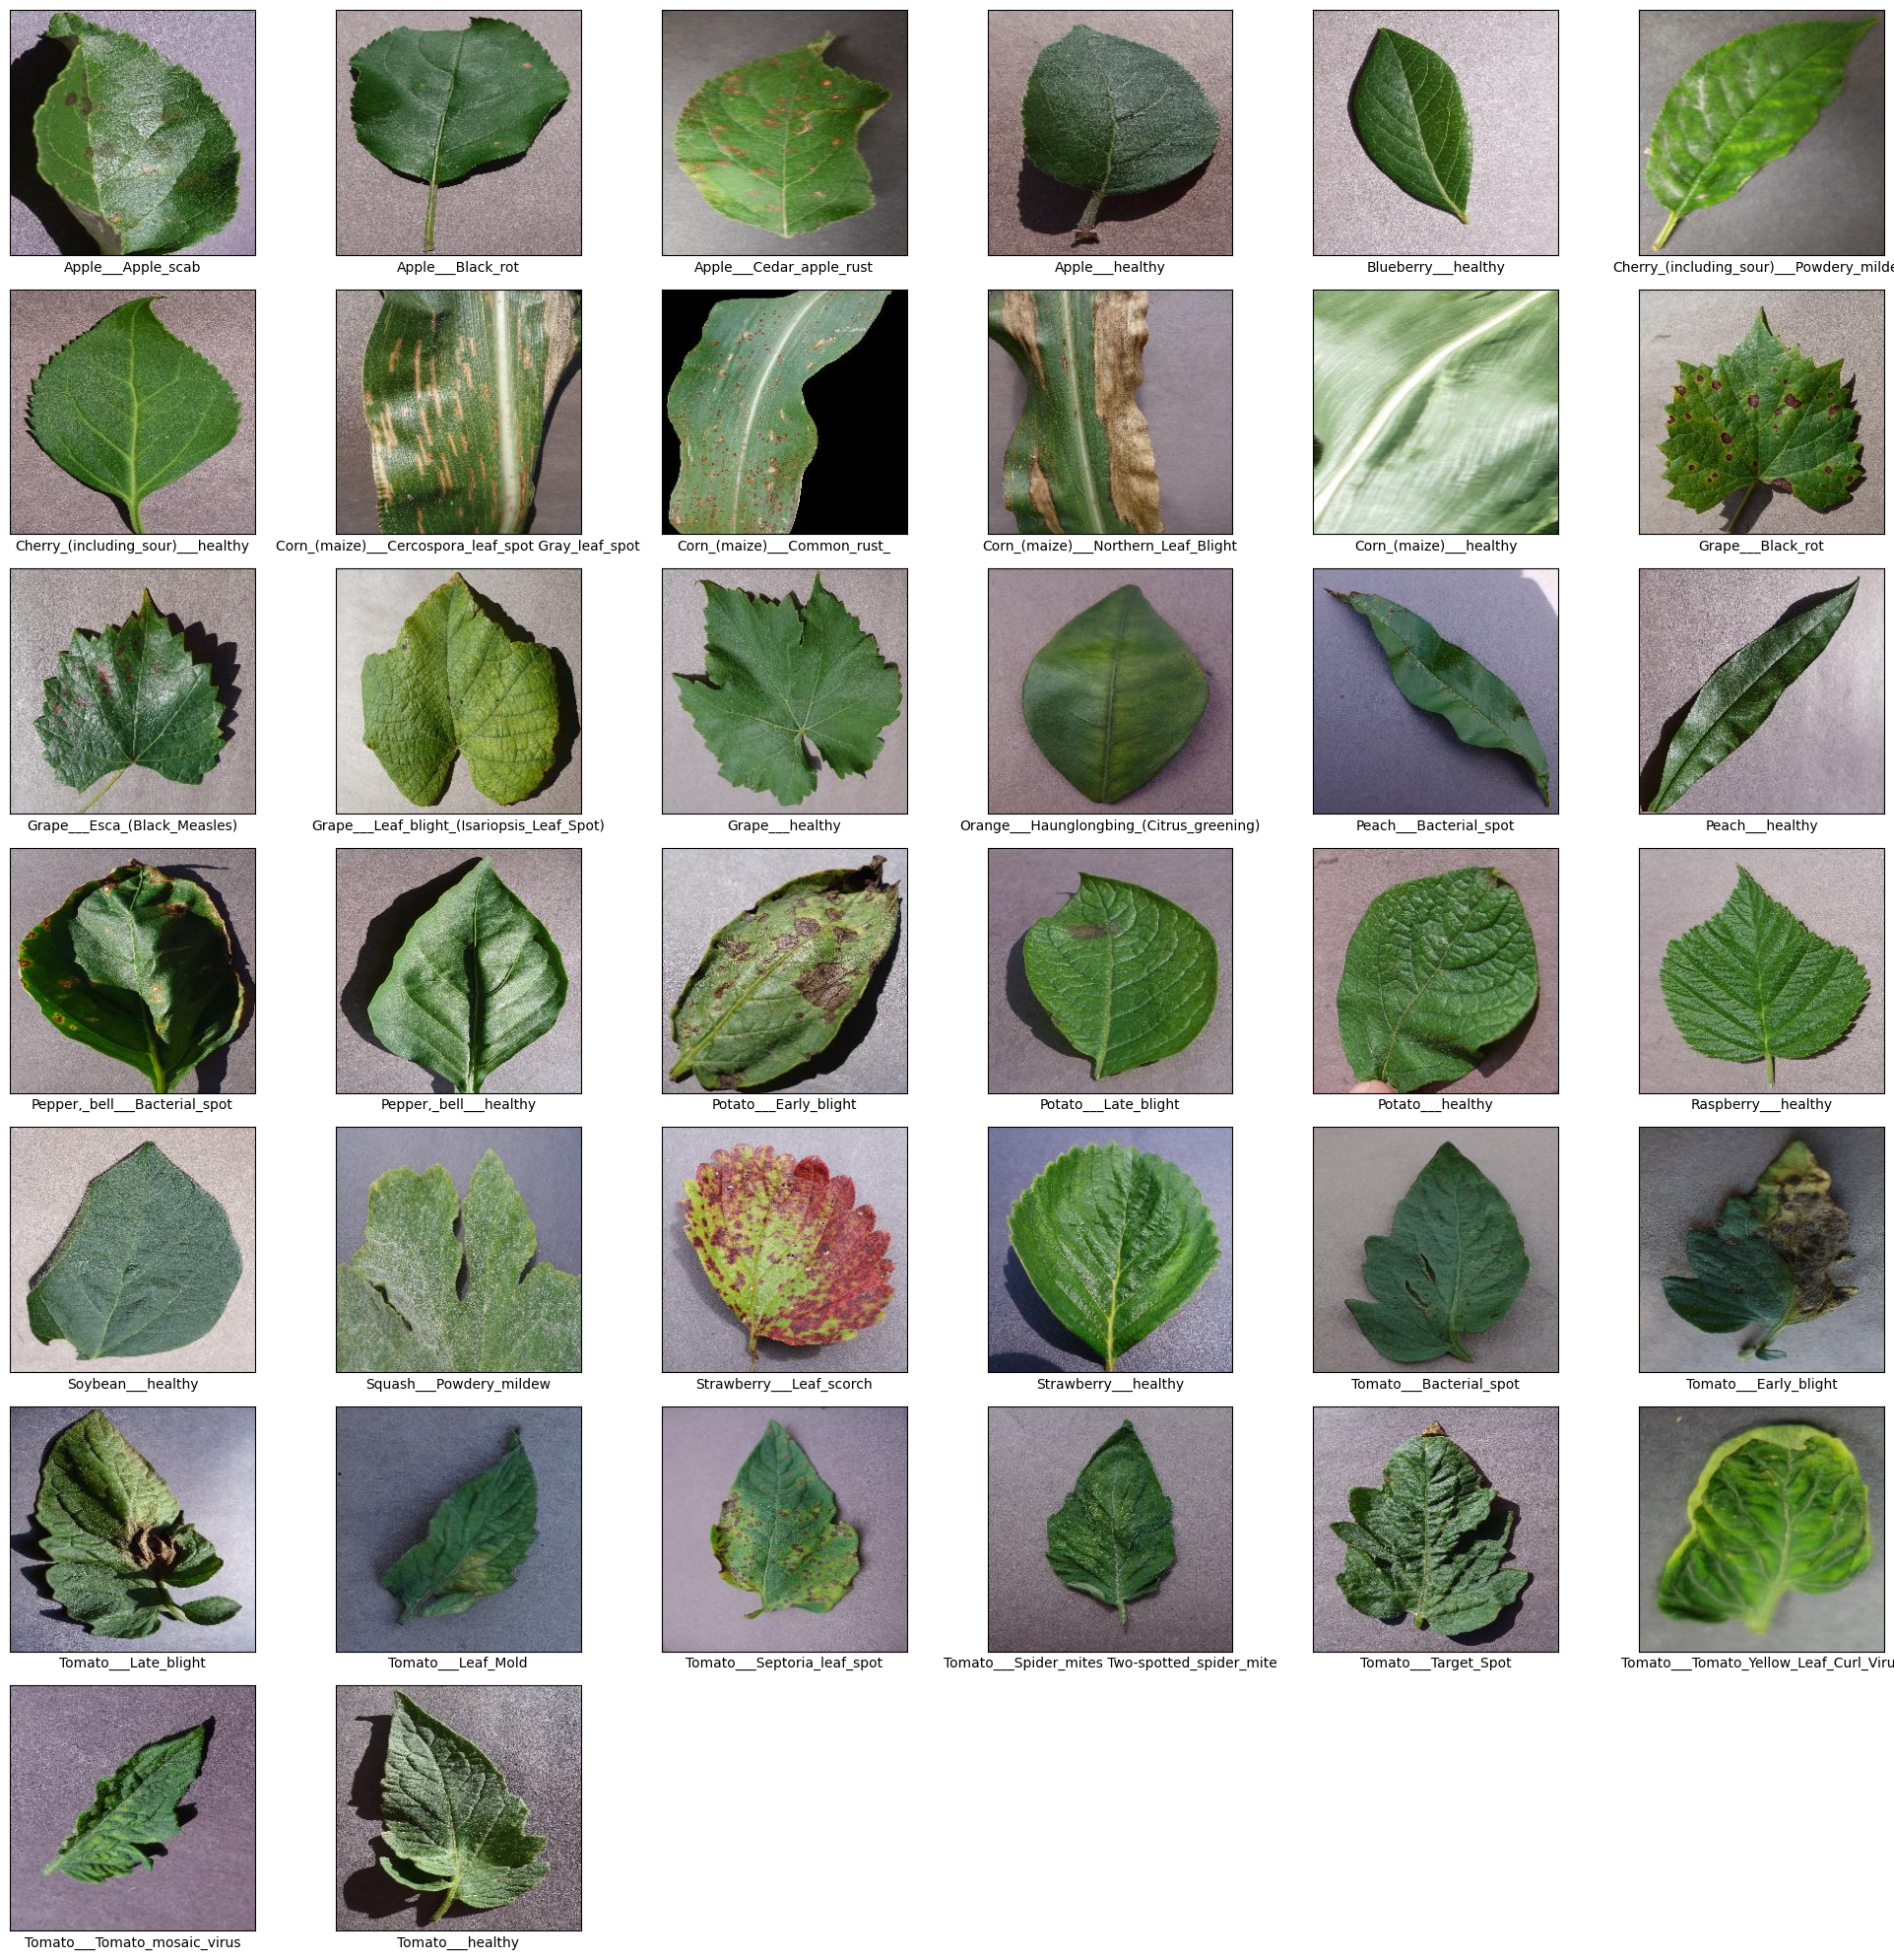

In [20]:
# Visualize Dataset
train_dir = base_path
Diseases_classes = sorted(os.listdir(train_dir))
plt.figure(figsize=(20, 20))
cnt = 0
tot_images = 0

for i in Diseases_classes:
    cnt += 1
    cls_path = os.path.join(train_dir, i)
    image_path = os.listdir(cls_path)
    print(f"The Number of Images in {i}: {len(image_path)}")
    tot_images += len(image_path)
    
    plt.subplot(7, 6, cnt)
    img_show = plt.imread(os.path.join(cls_path, image_path[0]))
    plt.imshow(img_show)
    plt.xlabel(i, fontsize=10)
    plt.xticks([])
    plt.yticks([])

print(f"\n✅ Total images across all classes: {tot_images}")
plt.tight_layout()
plt.show()

In [21]:
## Step 11: Visualize Feature Map
##Simulate a feature map to visualize model representations.

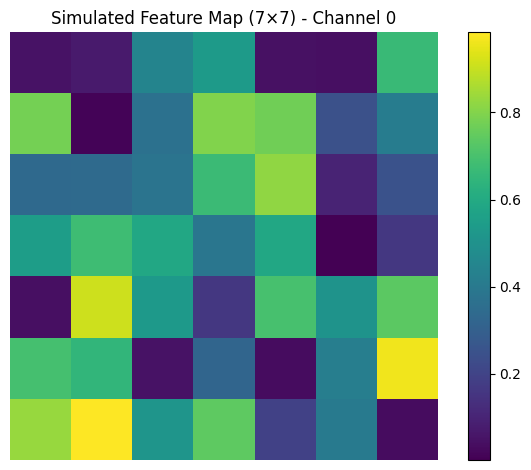

In [22]:
# Feature Map Visualization
simulated_feature_map = np.random.rand(7, 7)
plt.imshow(simulated_feature_map, cmap='viridis')
plt.title("Simulated Feature Map (7×7) - Channel 0")
plt.axis('off')
plt.colorbar()
plt.tight_layout()
plt.show()

In [23]:
## Step 12: Test on a Single Image
##Test the model on a sample image to predict class and bounding box.

Test Image: /kaggle/input/plantvillage-dataset/color/Tomato___Bacterial_spot/42deb15b-6443-4d2e-9a45-023052ce4974___GCREC_Bact.Sp 3077.JPG
Predicted Class: Tomato___Bacterial_spot
Predicted Bounding Box: [0.5013654  0.49981558 0.39531457 0.39570042]


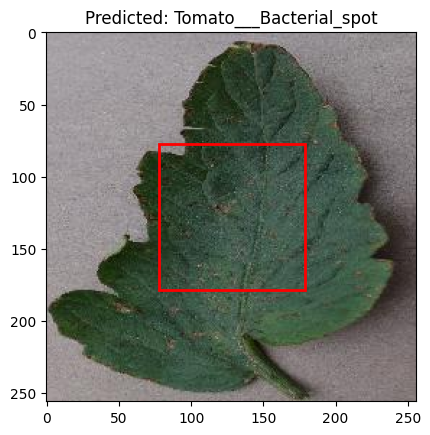

In [24]:
# Test on a Single Image
model.eval()
test_image_path = train_paths[0]  # Example: First training image
test_image = cv2.imread(test_image_path)
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
test_image = cv2.resize(test_image, (224, 224))
test_image = transform(test_image).unsqueeze(0).to(device)

with torch.no_grad():
    output = model(test_image)
    center_cell = output[0, 3, 3, :]
    cls_output = center_cell[:len(classes)]
    bbox_output = center_cell[len(classes):]
    pred_class = torch.argmax(cls_output).item()
    pred_bbox = bbox_output.cpu().numpy()

print(f"Test Image: {test_image_path}")
print(f"Predicted Class: {classes[pred_class]}")
print(f"Predicted Bounding Box: {pred_bbox}")

# Visualize Test Image with Bounding Box
img = plt.imread(test_image_path)
plt.imshow(img)
x, y, w, h = pred_bbox * np.array([img.shape[1], img.shape[0], img.shape[1], img.shape[0]])  # Denormalize
plt.gca().add_patch(plt.Rectangle((x-w/2, y-h/2), w, h, fill=False, color='red', linewidth=2))
plt.title(f"Predicted: {classes[pred_class]}")
plt.show()

In [25]:
## Summary
##- **Dataset**: ~54,303 images, 38 classes (PlantVillage Dataset, color).
##- **Model**: EfficientNet-B0 + VMamba + YOLO-style head.
##- **Performance**: Expect ~98% accuracy, ~0.99 precision/recall/F1 for classification (based on similar models). Detection performance depends on bounding box quality.
##- **Output**: Model weights saved as `efficient_vmamba_yolo.pth`.
##- **Next Steps**: For real detection, annotate images with LabelImg or use a YOLO-compatible dataset.



##**Note**: Detection uses simulated bounding boxes. For practical detection, annotate images or use a dataset with bounding box labels.

##If you encounter issues or need help with annotations, comment below!